<a href="https://colab.research.google.com/github/davidlealo/cft_estatales_analisis/blob/main/analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de discurso
Instalación de API de Anthropic para el análisis de datos con la tecnología de Sonnet (específicamente claude-3-sonnet-20240229)

Lo primero es tomar la información de la clave secreta como variable de entorno a través de un input que protege la información privada de la API KEY

In [ ]:
# Instalar las bibliotecas necesarias
%pip install anthropic
%pip install PyPDF2
%pip install python-dotenv

In [3]:
import os
from dotenv import load_dotenv
from anthropic import Anthropic
from IPython.display import display, HTML

def setup_api_key():
    """Configura la API key de Anthropic desde .env o entrada manual"""

    # Intenta cargar desde .env
    load_dotenv()
    api_key = os.getenv("ANTHROPIC_API_KEY")

    if not api_key:
        # HTML para input manual
        display(HTML("""
            <div style="margin: 20px; padding: 20px; border: 1px solid #ccc;">
                <h3>Anthropic API Key</h3>
                <input type="password" id="api_key" style="width: 100%; padding: 5px;">
                <button onclick="
                    var key = document.getElementById('api_key').value;
                    google.colab.kernel.invokeFunction('notebook.store_key', [key]);
                    ">Guardar API Key</button>
            </div>
        """))

        def store_key(key):
            os.environ["ANTHROPIC_API_KEY"] = key
            return "API key almacenada"

        output.register_callback('notebook.store_key', store_key)
        return None

    return Anthropic(api_key=api_key)

# Uso:
client = setup_api_key()

In [4]:
import requests
from bs4 import BeautifulSoup
import PyPDF2
from io import BytesIO
from anthropic import Anthropic
import os

def download_and_process_documents():
    try:
        # URLs
        law_url = "https://www.bcn.cl/leychile/navegar?idNorma=1088775"
        ministry_url = "https://educacionsuperior.mineduc.cl/cft-estatales/"
        pdf_url = "https://educacionsuperior.mineduc.cl/wp-content/uploads/sites/49/2022/08/Plan-fortal-CFTE-VF.pdf"

        print("Descargando documentos...")

        # Descargar ley
        law_response = requests.get(law_url)
        law_soup = BeautifulSoup(law_response.text, 'html.parser')
        law_content = law_soup.find('div', {'id': 'normaText'})
        law_text = law_content.get_text() if law_content else "No se pudo extraer el texto de la ley"

        # Descargar información ministerial
        ministry_response = requests.get(ministry_url)
        ministry_soup = BeautifulSoup(ministry_response.text, 'html.parser')
        ministry_text = ministry_soup.get_text()

        # Descargar PDF
        pdf_response = requests.get(pdf_url)
        pdf_file = BytesIO(pdf_response.content)
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pdf_text = "\n".join(page.extract_text() for page in pdf_reader.pages)

        print("Documentos descargados exitosamente")
        return law_text, f"{ministry_text}\n\n{pdf_text}"

    except Exception as e:
        print(f"Error al descargar documentos: {str(e)}")
        return "", ""

def analyze_cft_policy(law_text, ministry_docs):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "Error: ANTHROPIC_API_KEY no encontrada"

    client = Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

    system_prompt = "Analiza la Ley 20.910 sobre CFTs estatales y su implementación según documentos ministeriales."

    user_message = f"""
    Analiza los siguientes documentos:

    LEY 20.910: {law_text}
    DOCUMENTOS MINISTERIALES: {ministry_docs}

    Realiza un análisis considerando:
    1. Marco legal y objetivos establecidos en Ley 20.910
    2. Avances en implementación según Plan de Fortalecimiento
    3. Cumplimiento de hitos y metas
    4. Financiamiento y recursos asignados
    5. Articulación territorial

    Estructura obligatoria:
    - Análisis del marco normativo
    - Estado actual de implementación por región
    - Cumplimiento de objetivos legales
    - Evaluación del plan de fortalecimiento
    - Brechas y desafíos pendientes
    """

    try:
        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=4096,
            system=system_prompt,
            messages=[{"role": "user", "content": user_message}]
        )
        return response.content[0].text
    except Exception as e:
        return f"Error en el análisis: {str(e)}"

def main():
    print("Iniciando análisis...")
    law_text, ministry_docs = download_and_process_documents()
    analysis = analyze_cft_policy(law_text, ministry_docs)

    with open("analisis_normativa_cft.txt", "w", encoding='utf-8') as f:
        f.write(analysis)
    print("Análisis completado y guardado")

if __name__ == "__main__":
    main()

Iniciando análisis...
Descargando documentos...
Documentos descargados exitosamente


<ipython-input-4-8ff36c92d2a4>:71: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis completado y guardado


Hojas encontradas en el archivo: ['Estudiantes', 'Academicos', 'Gratuidad', 'Infraestructura', 'Retención', 'Matricula']
    Año                           Institución  \
0  2023  C.F.T. ESTATAL DE ARICA Y PARINACOTA   
1  2023            C.F.T. ESTATAL DE TARAPACÁ   
2  2023         C.F.T. ESTATAL DE ANTOFAGASTA   
3  2023             C.F.T. ESTATAL DE ATACAMA   
4  2023            C.F.T. ESTATAL DE COQUIMBO   

   Matrícula Femenina/Matrícula Total  Matrícula Masculina/Matrícula Total  \
0                               0.564                                0.436   
1                               0.723                                0.277   
2                               0.650                                0.350   
3                               0.638                                0.362   
4                               0.530                                0.470   

   Matrícula entre 15 y 24 Años/ Matrícula Total  \
0                                          0.421   
1          

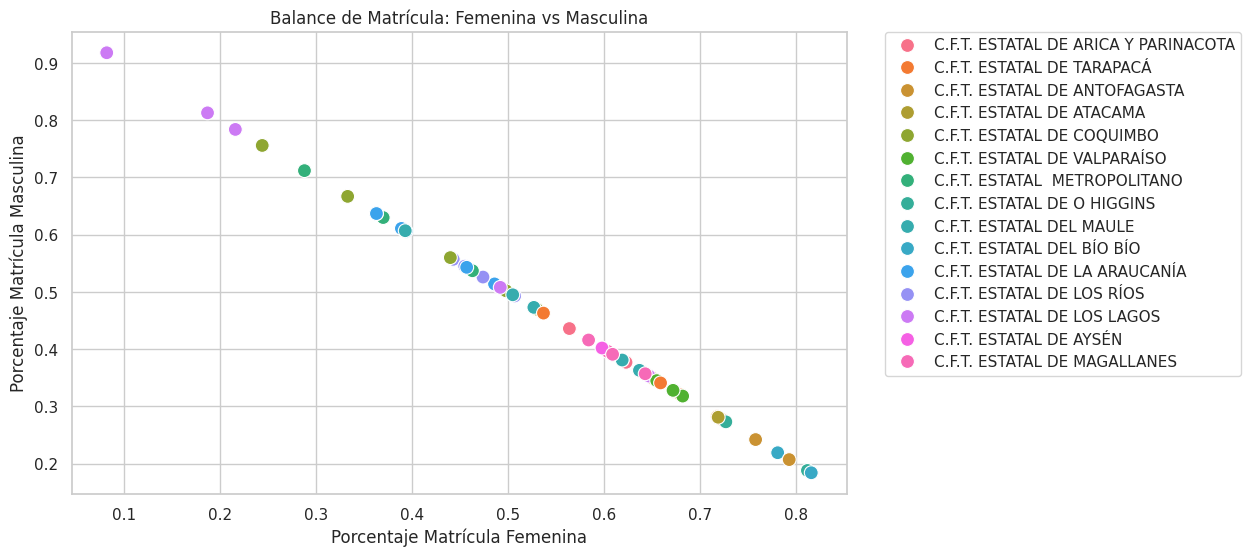

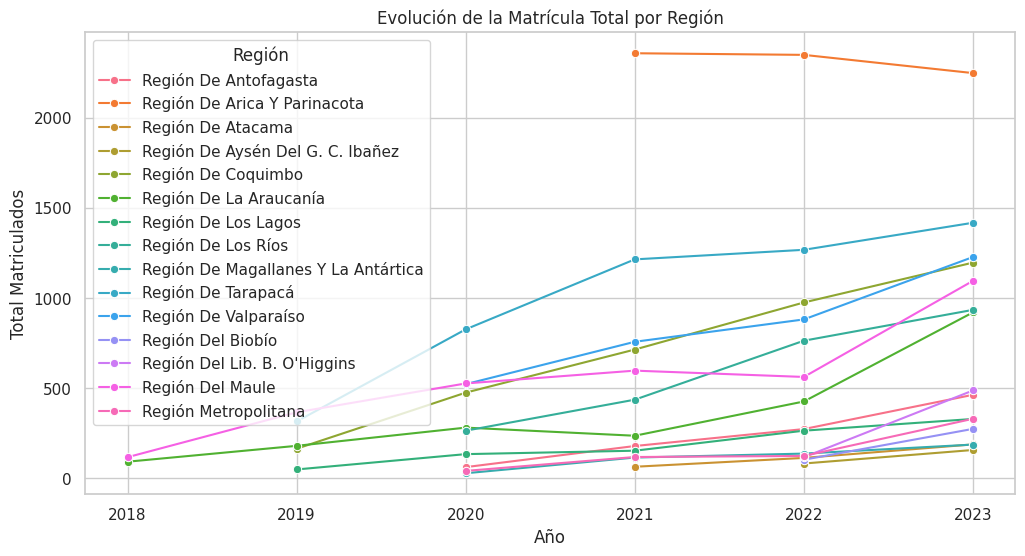

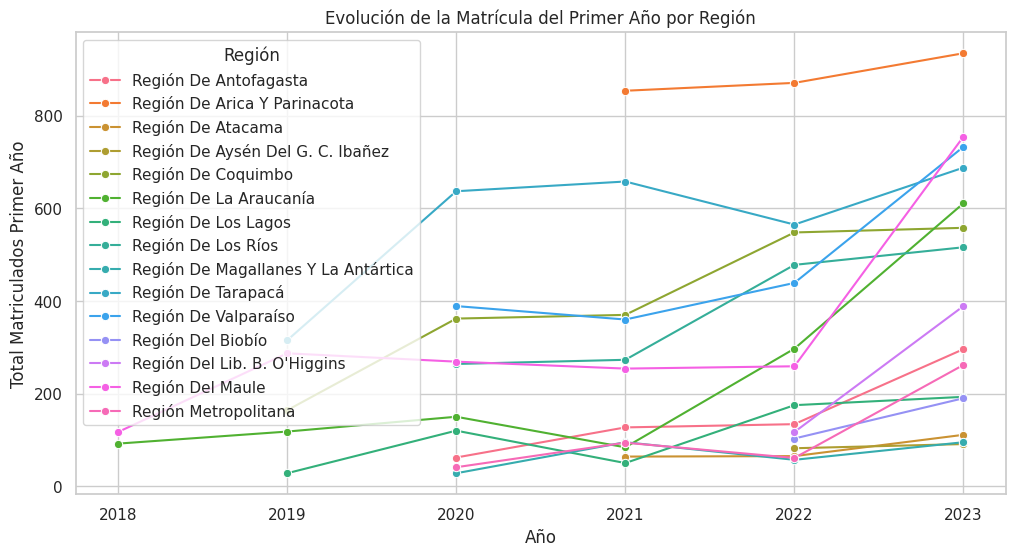

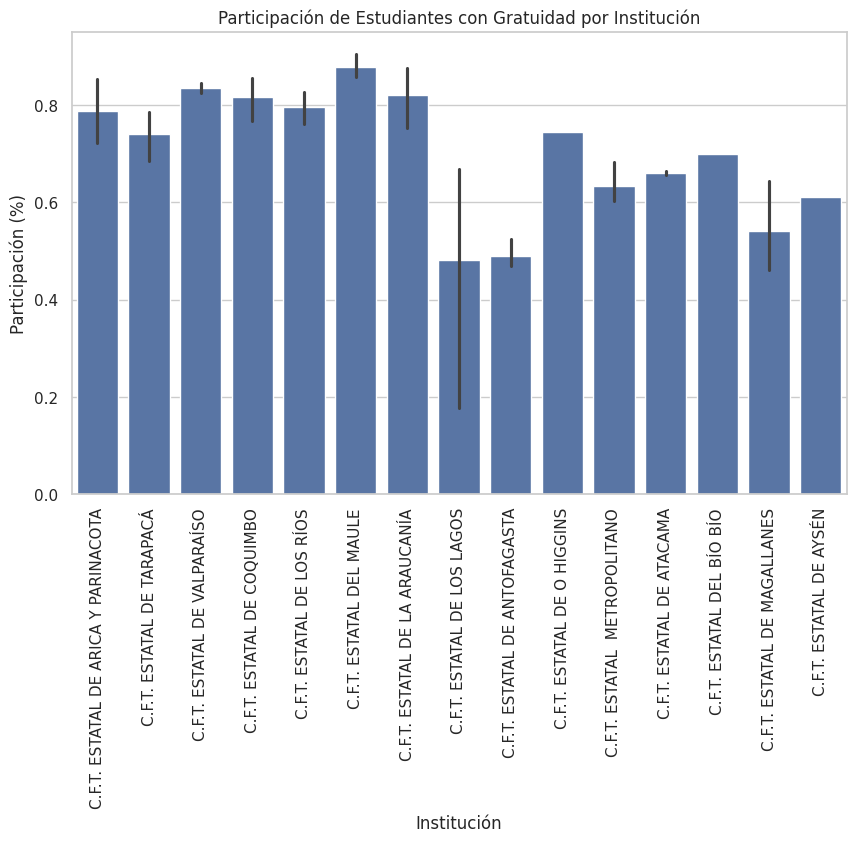

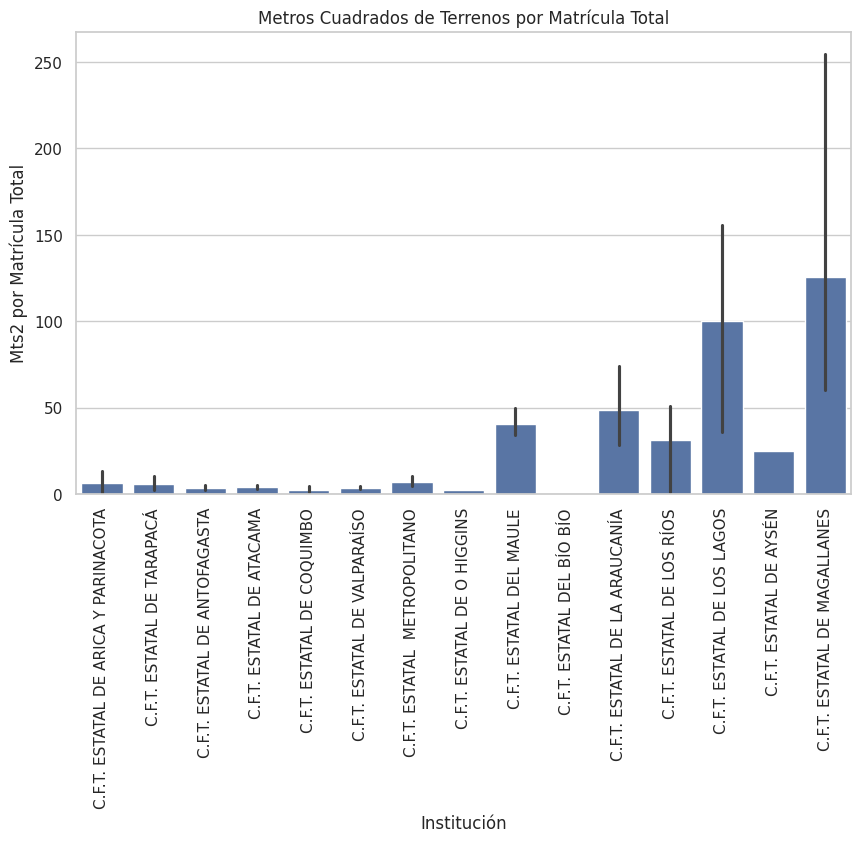

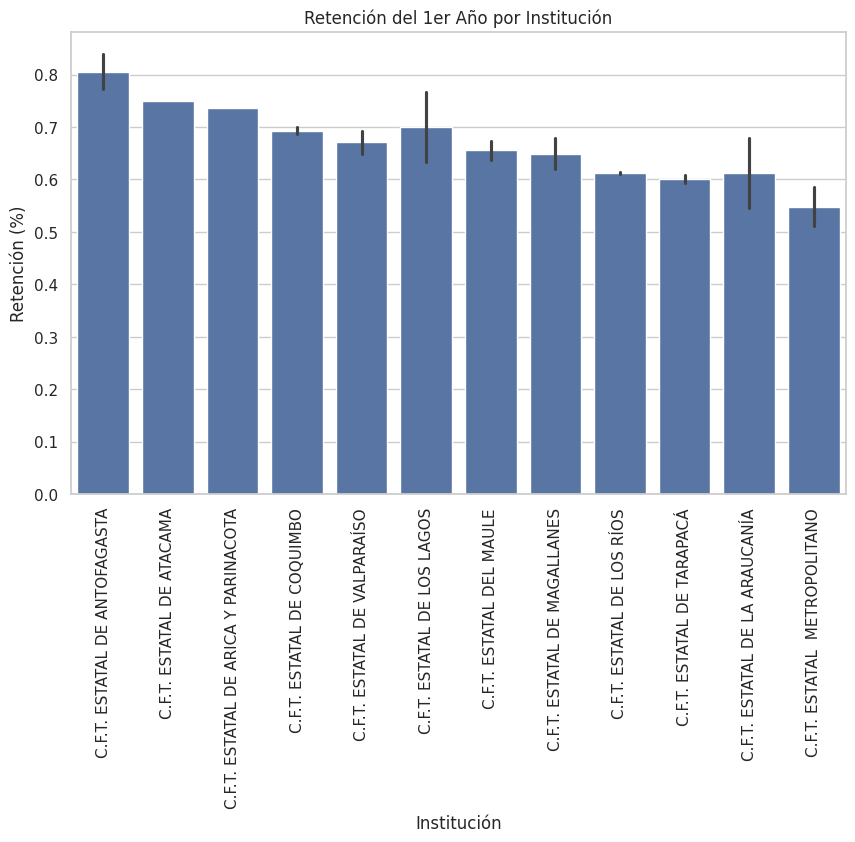

Análisis completado.


In [5]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
sns.set(style="whitegrid")
%matplotlib inline

# 1. Cargar el archivo Excel con todas sus hojas
file_name = "06_Base_de_Datos_CFT Estatal.xlsx"  # Asegúrate de que el archivo esté en el mismo directorio o especifica la ruta correcta
xls = pd.ExcelFile(file_name)
print("Hojas encontradas en el archivo:", xls.sheet_names)

# Cargar cada hoja en un DataFrame (asegúrate de que los nombres de las hojas coincidan con los del archivo)
df_estudiantes    = pd.read_excel(file_name, sheet_name="Estudiantes")
df_academicos     = pd.read_excel(file_name, sheet_name="Academicos")
df_gratuidad      = pd.read_excel(file_name, sheet_name="Gratuidad")
df_infraestructura= pd.read_excel(file_name, sheet_name="Infraestructura")
df_retencion      = pd.read_excel(file_name, sheet_name="Retención")
df_matricula      = pd.read_excel(file_name, sheet_name="Matricula")

# 2. Función para convertir columnas que contienen números escritos con coma decimal y/o con el símbolo "%" a valores numéricos
def convert_columns(df, exclude_cols):
    """
    Convierte a numérico las columnas (excluyendo las especificadas) que puedan tener coma decimal y/o símbolo de porcentaje.
    """
    for col in df.columns:
        if col not in exclude_cols:
            # Convertir a string, quitar el símbolo de porcentaje y reemplazar la coma por punto
            df[col] = df[col].astype(str).str.replace('%','').str.replace(',','.')
            # Convertir a numérico; si falla, deja NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Aplicar conversión en cada DataFrame, dejando las columnas identificadoras sin tocar
df_estudiantes     = convert_columns(df_estudiantes, ['Año', 'Institución'])
df_academicos      = convert_columns(df_academicos, ['Año', 'Institución'])
df_gratuidad       = convert_columns(df_gratuidad, ['Año', 'Institución'])
df_infraestructura = convert_columns(df_infraestructura, ['Año', 'Institución'])
df_retencion       = convert_columns(df_retencion, ['Año', 'Institución'])
df_matricula       = convert_columns(df_matricula, ['Año', 'Región', 'Comuna', 'Institución'])

# Verificación rápida de los datos convertidos (por ejemplo, las primeras filas de "Estudiantes")
print(df_estudiantes.head())

# 3. Ejemplos de análisis y visualizaciones

# --- Visualización 1: Balance de matrícula por género ---
# Suponiendo que en df_estudiantes tienes columnas como "Matrícula Femenina/Matrícula Total" y "Matrícula Masculina/Matrícula Total"
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_estudiantes,
    x='Matrícula Femenina/Matrícula Total',
    y='Matrícula Masculina/Matrícula Total',
    hue='Institución',
    s=100
)
plt.title("Balance de Matrícula: Femenina vs Masculina")
plt.xlabel("Porcentaje Matrícula Femenina")
plt.ylabel("Porcentaje Matrícula Masculina")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# --- Visualización 2: Evolución de la matrícula total y de primer año por región ---
# Agrupar el DataFrame de matrícula por Región y Año
df_matricula_grouped = df_matricula.groupby(['Región','Año']).agg({
    'Total Matriculados': 'sum',
    'Total Matriculados Primer Año': 'sum'
}).reset_index()

# Gráfico para Total Matriculados
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_matricula_grouped,
    x='Año',
    y='Total Matriculados',
    hue='Región',
    marker='o'
)
plt.title("Evolución de la Matrícula Total por Región")
plt.ylabel("Total Matriculados")
plt.show()

# Gráfico para Matriculados de Primer Año
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_matricula_grouped,
    x='Año',
    y='Total Matriculados Primer Año',
    hue='Región',
    marker='o'
)
plt.title("Evolución de la Matrícula del Primer Año por Región")
plt.ylabel("Total Matriculados Primer Año")
plt.show()

# --- Visualización 3: Análisis de Gratuidad ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_gratuidad,
    x='Institución',
    y='Participación Estudiantes con Gratuidad'
)
plt.title("Participación de Estudiantes con Gratuidad por Institución")
plt.xticks(rotation=90)
plt.ylabel("Participación (%)")
plt.show()

# --- Visualización 4: Infraestructura - Metros cuadrados de terrenos por Matrícula Total ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_infraestructura,
    x='Institución',
    y='Mts2 de Terrenos/Matrícula Total'
)
plt.title("Metros Cuadrados de Terrenos por Matrícula Total")
plt.xticks(rotation=90)
plt.ylabel("Mts2 por Matrícula Total")
plt.show()

# --- Visualización 5: Retención del 1er Año ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_retencion,
    x='Institución',
    y='Retención 1er año'
)
plt.title("Retención del 1er Año por Institución")
plt.xticks(rotation=90)
plt.ylabel("Retención (%)")
plt.show()

# 4. Posibles extensiones del análisis:
#    - Calcular la relación Académicos/Estudiantes a partir de df_academicos y df_estudiantes.
#    - Analizar correlaciones entre variables: por ejemplo, ¿existe relación entre la infraestructura (m2 por estudiante) y la retención?
#    - Comparar tendencias por años y regiones, o fusionar información de diferentes hojas (usando "Año" e "Institución" como claves).

print("Análisis completado.")


# Análisis de matrícula

In [6]:
import pandas as pd


file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'

# Cargar el archivo Excel y listar las hojas disponibles
xls = pd.ExcelFile(file_path)
print("Hojas disponibles en el archivo:")
print(xls.sheet_names)


Hojas disponibles en el archivo:
['Índice', 'Matrícula Total 2023', 'Evolución Matrícula Total', 'Matrícula Pregrado 2023', 'Evolución Matrícula Pregrado', 'Matrícula Posgrado 2023', 'Evolución Matrícula Posgrado', 'Matrícula Postitulo 2023', 'Evolución Matrícula Postítulo', 'Matrícula 2023 PPOO', 'Matrícula 2023 (Con discapac.)', 'Listado de instituciones 2023']


In [7]:
import pandas as pd

file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'
xls = pd.ExcelFile(file_path)
print("Hojas disponibles en el archivo:")
print(xls.sheet_names)


Hojas disponibles en el archivo:
['Índice', 'Matrícula Total 2023', 'Evolución Matrícula Total', 'Matrícula Pregrado 2023', 'Evolución Matrícula Pregrado', 'Matrícula Posgrado 2023', 'Evolución Matrícula Posgrado', 'Matrícula Postitulo 2023', 'Evolución Matrícula Postítulo', 'Matrícula 2023 PPOO', 'Matrícula 2023 (Con discapac.)', 'Listado de instituciones 2023']


In [8]:
import pandas as pd

file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'
# Ejemplo: Cargar la hoja "Matrícula Total 2023" sin encabezados
df = pd.read_excel(file_path, sheet_name="Matrícula Total 2023", header=None)
print("Contenido completo (primeras 50 filas):")
print(df.head(50))


Contenido completo (primeras 50 filas):
                                                    0                  1  \
0                                MATRÍCULA TOTAL 2023                NaN   
1   *Incluye programas de Pregrado, Posgrado y Pos...                NaN   
2                                                 NaN                NaN   
3   Matricula Total 2023 por tipo de institución y...                NaN   
4                                 Tipo de institución           Pregrado   
5                        Centros de Formación Técnica             136725   
6                            Institutos Profesionales             419014   
7                                       Universidades             693662   
8                                       Total general            1249401   
9                                                 NaN                NaN   
10  Matricula Total 2023 por tipo de institución y...                NaN   
11                                Tipo de instit

In [9]:
def extraer_tabla(df, inicio, fin, cols=None, header_row=None):
    """
    Extrae una tabla de un DataFrame a partir de un rango de filas y columnas.

    Parámetros:
      - df: DataFrame completo
      - inicio: índice de la primera fila de la tabla (inclusive)
      - fin: índice de la última fila de la tabla (inclusive)
      - cols: tupla (inicio_col, fin_col) para seleccionar columnas (opcional)
      - header_row: índice de la fila que contiene los encabezados (dentro del rango a extraer)

    Retorna:
      - DataFrame con la tabla extraída (con encabezados si se especificó)
    """
    if cols is not None:
        tabla = df.iloc[inicio:fin+1, cols[0]:cols[1]]
    else:
        tabla = df.iloc[inicio:fin+1]
    if header_row is not None:
        # header_row es el índice real de la fila en df que contiene los encabezados
        nuevos_encabezados = tabla.iloc[header_row - inicio]
        tabla = tabla.iloc[header_row - inicio + 1:]
        tabla.columns = nuevos_encabezados
    return tabla

# Ejemplo de uso: extraer la primera tabla con encabezados en la fila 3 (dentro del rango 3 a 10)
tabla1 = extraer_tabla(df, inicio=3, fin=10, cols=(0,6), header_row=3)
print("Tabla 1 extraída con función:")
print(tabla1.head())


Tabla 1 extraída con función:
3 Matricula Total 2023 por tipo de institución y nivel de formación       NaN  \
4                                Tipo de institución                 Pregrado   
5                       Centros de Formación Técnica                   136725   
6                           Institutos Profesionales                   419014   
7                                      Universidades                   693662   
8                                      Total general                  1249401   

3       NaN        NaN              NaN  
4  Posgrado  Postítulo  Matrícula Total  
5         0          9           136734  
6         0        418           419432  
7     52312      39299           785273  
8     52312      39726          1341439  


In [10]:
import requests
import zipfile
import io
import os
import pandas as pd

# Paso 2: Descargar el archivo ZIP desde la URL
url = "https://www.mifuturo.cl/wp-content/uploads/2024/07/MAT_2007_2024_WEB_02072024.zip"
print("Descargando archivo ZIP...")
r = requests.get(url)
if r.status_code == 200:
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo:", r.status_code)

# Paso 3: Abrir el archivo ZIP sin escribirlo en disco (usando un buffer en memoria)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))

# Listar los archivos contenidos en el ZIP
files_in_zip = zip_file.namelist()
print("Archivos contenidos en el ZIP:")
print(files_in_zip)

# Paso 4: Extraer los archivos en un directorio (por ejemplo, "data_matricula")
extract_path = "data_matricula"
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

zip_file.extractall(path=extract_path)
print(f"Archivos extraídos en la carpeta: {extract_path}")

# Paso 5: Explorar los archivos extraídos
# Por ejemplo, listamos los nombres de archivos y verificamos la extensión
extracted_files = os.listdir(extract_path)
print("Archivos extraídos:")
for f in extracted_files:
    print(f)

# Paso 6: Leer uno de los archivos con pandas (suponiendo que es un CSV)
# (Ajusta el nombre del archivo según lo que encuentres en la lista)
# Por ejemplo, si el archivo se llama "MAT_2007_2024_WEB.csv":
csv_file = os.path.join(extract_path, "MAT_2007_2024_WEB.csv")
if os.path.exists(csv_file):
    # Puedes necesitar ajustar parámetros de lectura, como el separador, codificación, etc.
    df = pd.read_csv(csv_file, encoding="utf-8", sep=",")
    print("Primeras filas del DataFrame:")
    print(df.head())
else:
    print(f"No se encontró el archivo {csv_file}. Revisa los nombres y extenciones.")

# Paso 7: Análisis exploratorio básico
print("Información general del DataFrame:")
print(df.info())
print("Estadísticas descriptivas:")
print(df.describe())

# Ejemplo de visualización (requerirá que identifiques columnas de interés)
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que en el DataFrame hay una columna 'Año' y una columna 'Matrícula Total'
if 'Año' in df.columns and 'Matrícula Total' in df.columns:
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df, x='Año', y='Matrícula Total', marker='o')
    plt.title("Evolución de la Matrícula Total")
    plt.xlabel("Año")
    plt.ylabel("Matrícula Total")
    plt.show()
else:
    print("Las columnas 'Año' o 'Matrícula Total' no se encuentran en el DataFrame. Revisa la estructura de los datos.")


Descargando archivo ZIP...
Archivo descargado exitosamente.
Archivos contenidos en el ZIP:
['MAT_2007_2024_WEB_02072024.csv']
Archivos extraídos en la carpeta: data_matricula
Archivos extraídos:
MAT_2007_2024_WEB_02072024.csv
No se encontró el archivo data_matricula/MAT_2007_2024_WEB.csv. Revisa los nombres y extenciones.
Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       70 non-null     object
 1   1       58 non-null     object
 2   2       58 non-null     object
 3   3       58 non-null     object
 4   4       58 non-null     object
dtypes: object(5)
memory usage: 3.1+ KB
None
Estadísticas descriptivas:
                    0                  1   2   3                4
count              70                 58  58  58               58
unique             49                 48  44  12               37
top     Total gen

## 1. Explorar el archivo para entender su estructura


In [13]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"

# Prueba con la codificación 'latin1'
df = pd.read_csv(csv_file, header=None, encoding='latin1', sep=';')

# Si falla, prueba con 'utf-8'
if df.empty:
    df = pd.read_csv(csv_file, header=None, encoding='utf-8', sep=';')


print("Primeras 20 filas del archivo:")
print(df.head(20))



<ipython-input-13-0ca238a8660b>:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,12,29,32,33,36,37,38,39,40,41,42,43,47,48,49,50,51,52,53,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, header=None, encoding='latin1', sep=';')


Primeras 20 filas del archivo:
          0                   1                                  2   \
0        AÑO  TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA   
1   MAT_2024                  77                                 24   
2   MAT_2024                 550                                346   
3   MAT_2024                  82                                 65   
4   MAT_2024                 704                                567   
5   MAT_2024                   7                                  7   
6   MAT_2024                  11                                  5   
7   MAT_2024                  61                                  7   
8   MAT_2024                  14                                  6   
9   MAT_2024                 109                                 53   
10  MAT_2024                  19                                  9   
11  MAT_2024                   1                                NaN   
12  MAT_2024                  84              

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248174 entries, 0 to 248173
Data columns (total 59 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       248174 non-null  object
 1   1       248174 non-null  object
 2   2       229244 non-null  object
 3   3       228631 non-null  object
 4   4       17 non-null      object
 5   5       172886 non-null  object
 6   6       159895 non-null  object
 7   7       159418 non-null  object
 8   8       7 non-null       object
 9   9       248174 non-null  object
 10  10      248174 non-null  object
 11  11      248174 non-null  object
 12  12      248174 non-null  object
 13  13      248174 non-null  object
 14  14      248174 non-null  object
 15  15      248174 non-null  object
 16  16      248174 non-null  object
 17  17      248174 non-null  object
 18  18      248174 non-null  object
 19  19      248174 non-null  object
 20  20      248174 non-null  object
 21  21      248174 non-null  object
 

In [16]:
print("Columnas en el DataFrame:", df.columns.tolist())


Columnas en el DataFrame: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


In [17]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"

# Leer el CSV usando la codificación y el separador correcto; se usará la primera fila como encabezado.
df = pd.read_csv(csv_file, encoding='latin1', sep=';')
print("Primeras 20 filas del archivo con encabezados:")
print(df.head(20))

# Verificar los nombres de las columnas:
print("Columnas en el DataFrame:")
print(df.columns.tolist())


<ipython-input-17-1e96fbd028b1>:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Primeras 20 filas del archivo con encabezados:
         AÑO  TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA  \
0   MAT_2024                  77                               24.0   
1   MAT_2024                 550                              346.0   
2   MAT_2024                  82                               65.0   
3   MAT_2024                 704                              567.0   
4   MAT_2024                   7                                7.0   
5   MAT_2024                  11                                5.0   
6   MAT_2024                  61                                7.0   
7   MAT_2024                  14                                6.0   
8   MAT_2024                 109                               53.0   
9   MAT_2024                  19                                9.0   
10  MAT_2024                   1                                NaN   
11  MAT_2024                  84                               42.0   
12  MAT_2024                 1

In [18]:
# Valores unicos para columna AÑO
print(df['AÑO'].unique())

['MAT_2024' 'MAT_2023' 'MAT_2022' 'MAT_2021' 'MAT_2020' 'MAT_2019'
 'MAT_2018' 'MAT_2017' 'MAT_2016' 'MAT_2015' 'MAT_2014' 'MAT_2013'
 'MAT_2012' 'MAT_2011' 'MAT_2010' 'MAT_2009' 'MAT_2008' 'MAT_2007']


In [22]:
# DF de valores unicos de 'CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN'
df_unique = df[['CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN']].drop_duplicates()
print(df_unique)

        CÓDIGO DE INSTITUCIÓN            NOMBRE INSTITUCIÓN
0                           1  UNIVERSIDAD GABRIELA MISTRAL
61                          2      UNIVERSIDAD FINIS TERRAE
168                         3    UNIVERSIDAD DIEGO PORTALES
383                         4  UNIVERSIDAD CENTRAL DE CHILE
547                         7       UNIVERSIDAD BOLIVARIANA
...                       ...                           ...
246646                    208          CFT ESANE (SANTIAGO)
247171                    349                     CFT CEPSA
247260                    401                   CFT CENAFOM
247266                    409                    CFT ZIPTER
248113                    600             CFT CIMA DE RENGO

[220 rows x 2 columns]


In [23]:
# Export df_unique to csv
df_unique.to_csv('df_unique.csv', index=False)

### Filtrar solo los CFT estatales
Una estrategia es buscar en la columna "NOMBRE INSTITUCIÓN" la palabra "Estatal". (Revisa que el valor se escriba de esa forma en tus datos)


In [26]:
import pandas as pd

# Supongamos que ya has leído el CSV correctamente y está en el DataFrame df
# Si aún no lo has hecho, asegúrate de hacerlo:
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# 1. Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico (si no lo está)
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# 2. Filtrar los registros para CFT estatales (códigos entre 902 y 920)
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)]
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# 3. Extraer el año numérico de la columna "AÑO". Se asume que los valores son del tipo "MAT_2007", etc.
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)

# 4. Convertir la columna "TOTAL MATRICULADOS" a numérico
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# 5. Agrupar por año (AÑO_NUM) y sumar la matrícula total
evolucion_cft_estatal = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS"].sum().reset_index()

# 6. Visualizar los años disponibles en este subconjunto
print("Años disponibles en el subconjunto de CFT estatales:")
print(evolucion_cft_estatal["AÑO_NUM"].unique())


<ipython-input-26-95caff4f6787>:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Años disponibles en el subconjunto de CFT estatales:
[2018 2019 2020 2021 2022 2023 2024]


<ipython-input-26-95caff4f6787>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
<ipython-input-26-95caff4f6787>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["TOTAL MATRICULADOS"] = (
<ipython-input-26-95caff4f6787>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [27]:
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()


In [28]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# Filtrar registros de CFT estatales y crear una copia explícita
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# Extraer el año numérico de la columna "AÑO"
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
print("Años disponibles:", df_cft_estatal["AÑO_NUM"].unique())

# Convertir "TOTAL MATRICULADOS" a numérico
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# Agrupar por año y sumar la matrícula total
evolucion_cft_estatal = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS"].sum().reset_index()
print("Evolución de la matrícula de CFT estatales:")
print(evolucion_cft_estatal)


<ipython-input-28-c4f2b03666a3>:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Años disponibles: [2024 2023 2022 2021 2020 2019 2018]
Evolución de la matrícula de CFT estatales:
   AÑO_NUM  TOTAL MATRICULADOS
0     2018                 209
1     2019                1074
2     2020                3159
3     2021                6940
4     2022                8435
5     2023               11447
6     2024               15041


Evolución con variación porcentual año a año:
   AÑO_NUM  TOTAL MATRICULADOS  Variacion_pct
0     2018                 209            NaN
1     2019                1074     413.875598
2     2020                3159     194.134078
3     2021                6940     119.689775
4     2022                8435      21.541787
5     2023               11447      35.708358
6     2024               15041      31.396873
Variación global de la matrícula de CFT estatales de 2018 a 2024: 7096.65%


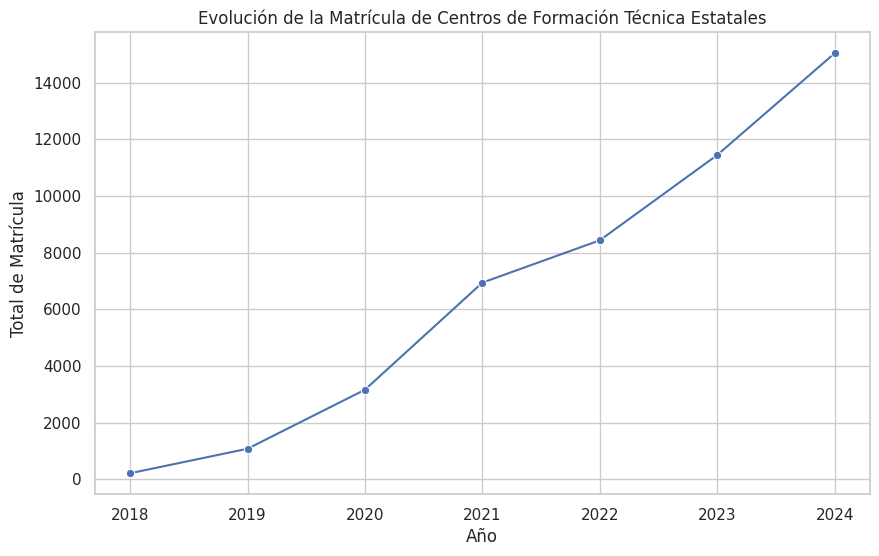

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'evolucion_cft_estatal' ya fue definido según el proceso anterior

# Calcular la variación porcentual año a año:
evolucion_cft_estatal["Variacion_pct"] = evolucion_cft_estatal["TOTAL MATRICULADOS"].pct_change() * 100
print("Evolución con variación porcentual año a año:")
print(evolucion_cft_estatal)

# Calcular la variación porcentual global entre el primer y último año disponible:
anio_inicio = evolucion_cft_estatal["AÑO_NUM"].min()  # 2018
anio_fin = evolucion_cft_estatal["AÑO_NUM"].max()       # 2024

# Extraer la matrícula del año de inicio y del año final:
matricula_inicio = evolucion_cft_estatal.loc[evolucion_cft_estatal["AÑO_NUM"] == anio_inicio, "TOTAL MATRICULADOS"].values[0]
matricula_fin = evolucion_cft_estatal.loc[evolucion_cft_estatal["AÑO_NUM"] == anio_fin, "TOTAL MATRICULADOS"].values[0]

variacion_global = ((matricula_fin - matricula_inicio) / matricula_inicio) * 100
print(f"Variación global de la matrícula de CFT estatales de {anio_inicio} a {anio_fin}: {variacion_global:.2f}%")

# Graficar la evolución
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_cft_estatal, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o")
plt.title("Evolución de la Matrícula de Centros de Formación Técnica Estatales")
plt.xlabel("Año")
plt.ylabel("Total de Matrícula")
plt.grid(True)
plt.show()


<ipython-input-30-01bb04204782>:7: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Columnas en el DataFrame:
['AÑO', 'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA', 'MATRICULADOS NO BINARIO POR CARRERA', 'TOTAL MATRICULADOS PRIMER AÑO', 'MATRICULADOS MUJERES PRIMER AÑO', 'MATRICULADOS HOMBRES PRIMER AÑO', 'MATRICULADOS NO BINARIO PRIMER AÑO', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 2', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 3', 'CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN', 'ACREDITACIÓN INSTITUCIONAL', 'REGIÓN', 'PROVINCIA', 'COMUNA', 'NOMBRE SEDE', 'NOMBRE CARRERA', 'ÁREA DEL CONOCIMIENTO', 'CINE-F 1997 ÁREA', 'CINE-F 1997 SUBAREA', 'ÁREA CARRERA GENÉRICA', 'CINE-F 2013 ÁREA', 'CINE-F 2013 SUBAREA', 'NIVEL GLOBAL', 'CARRERA CLASIFICACIÓN NIVEL 1', 'CARRERA CLASIFICACIÓN NIVEL 2', 'MODALIDAD', 'JORNADA', 'TIPO DE PLAN DE LA CARRERA', 'DURACIÓN ESTUDIO CARRERA', 'DURACIÓN TOTAL DE CARRERA', 'CÓDIGO CARRERA', 'ACREDITACIÓN CARRERA', 'TOTAL RANGO DE EDAD', 'RANGO DE EDAD 15 A 19 AÑOS', 'RANGO DE ED

<ipython-input-30-01bb04204782>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
<ipython-input-30-01bb04204782>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["TOTAL MATRICULADOS"] = (
<ipython-input-30-01bb04204782>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

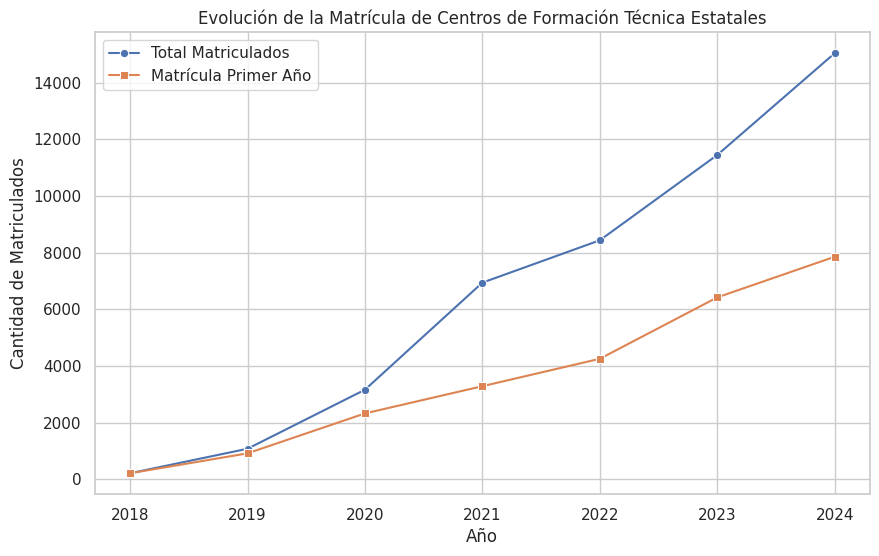

Variación porcentual de la matrícula total de CFT estatales de 2018 a 2024: 7096.65%


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya leíste el CSV con encabezados
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Verifica que los nombres de las columnas sean los correctos:
print("Columnas en el DataFrame:")
print(df.columns.tolist())
# Deberías ver algo similar a:
# ['AÑO', 'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA', ... , 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', ..., 'TOTAL MATRICULADOS PRIMER AÑO', ...]

# 1. Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# 2. Filtrar registros de CFT estatales: códigos entre 902 y 920
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)]
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# 3. Extraer el año numérico de la columna "AÑO"
# Los valores son de la forma "MAT_2007", "MAT_2008", etc.
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
print("Valores únicos de AÑO_NUM:", df_cft_estatal["AÑO_NUM"].unique())

# 4. Convertir las columnas de matrícula a numérico.
# Para "TOTAL MATRICULADOS":
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# Para "TOTAL MATRICULADOS PRIMER AÑO":
df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"] = (
    df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"], errors='coerce')

# 5. Agrupar por año y sumar la matrícula total y la matrícula de primer año
evolucion = df_cft_estatal.groupby("AÑO_NUM").agg({
    "TOTAL MATRICULADOS": "sum",
    "TOTAL MATRICULADOS PRIMER AÑO": "sum"
}).reset_index()

print("Evolución de la matrícula de CFT estatales por año:")
print(evolucion)

# 6. Graficar la evolución
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o", label="Total Matriculados")
sns.lineplot(data=evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS PRIMER AÑO", marker="s", label="Matrícula Primer Año")
plt.title("Evolución de la Matrícula de Centros de Formación Técnica Estatales")
plt.xlabel("Año")
plt.ylabel("Cantidad de Matriculados")
plt.legend()
plt.grid(True)
plt.show()

# 7. Para evaluar el impacto de la política (por ejemplo, comparar antes y después de 2016)
anio_inicio = 2018
anio_fin = evolucion["AÑO_NUM"].max()  # Último año disponible

matricula_inicio = evolucion.loc[evolucion["AÑO_NUM"] == anio_inicio, "TOTAL MATRICULADOS"].values[0]
matricula_fin = evolucion.loc[evolucion["AÑO_NUM"] == anio_fin, "TOTAL MATRICULADOS"].values[0]

variacion_pct = ((matricula_fin - matricula_inicio) / matricula_inicio) * 100
print(f"Variación porcentual de la matrícula total de CFT estatales de {anio_inicio} a {anio_fin}: {variacion_pct:.2f}%")
